In [1]:
from functools import partial

import torch.nn as nn
from fastai.basic_train import Learner
from fastai.train import ShowGraph
from fastai.data_block import DataBunch
from torch import optim

from dataset.fracnet_dataset import FracNetTrainDataset
from dataset import my_transforms as tsfm
from utils.metrics import dice, recall, precision, fbeta_score
from model.unet import UNet
from model.losses import MixLoss, DiceLoss
import torch
from dataset.my_transforms import RandomCrop, RandomFlip_LR, RandomFlip_UD, Center_Crop, Compose, Resize

/home/user/.local/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
def main(train_image_dir,train_label_dir,val_image_dir,val_label_dir, save_model):
#     train_image_dir = train_image_dir
#     train_label_dir = train_label_dir
#     val_image_dir = val_image_dir
#     val_label_dir = val_label_dir

    batch_size = 4
    num_workers = 4
    # optimizer = optim.SGD
    optimizer = optim.Adam
    criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)

    thresh = 0.1
    recall_partial = partial(recall, thresh=thresh)
    precision_partial = partial(precision, thresh=thresh)
    fbeta_score_partial = partial(fbeta_score, thresh=thresh)

    model = UNet(1, 1, first_out_channels=16)
    model = nn.DataParallel(model,device_ids=[0])

    transforms = [
        tsfm.Window(-200, 1000),
        tsfm.MinMaxNorm(-200, 1000)
    ]
    
    crop_size = 48
    
    my_transforms = Compose([
#                 RandomCrop(crop_size),
                RandomFlip_LR(prob=0.5),
                RandomFlip_UD(prob=0.5),
                # RandomRotate()
            ])
    
    ds_train = FracNetTrainDataset(train_image_dir, train_label_dir,
        transforms=transforms, my_transforms = my_transforms)
    dl_train = FracNetTrainDataset.get_dataloader(ds_train, batch_size, False,
        num_workers)
    ds_val = FracNetTrainDataset(val_image_dir, val_label_dir,
        transforms=transforms, my_transforms = my_transforms)
    dl_val = FracNetTrainDataset.get_dataloader(ds_val, batch_size, False,
        num_workers)

    databunch = DataBunch(dl_train, dl_val,
        collate_fn=FracNetTrainDataset.collate_fn)

    learn = Learner(
        databunch,
        model,
        opt_func=optimizer,
        loss_func=criterion,
        metrics=[dice, recall_partial, precision_partial, fbeta_score_partial]
    )

    learn.fit_one_cycle(
        20,
        1e-1,
        pct_start=0,
        div_factor=1000,
        callbacks=[
            ShowGraph(learn),
        ]
    )

    if save_model:
        torch.save(model.module.state_dict(), "./aug_model_weights.pth")

epoch,train_loss,valid_loss,dice,recall,precision,fbeta_score,time
0,0.799536,0.827718,0.254305,1.000000,0.414286,0.568662,15:00
1,0.657790,0.644574,0.395202,0.824140,0.401372,0.516781,15:20
2,0.584583,0.631747,0.410642,0.962062,0.482728,0.631129,17:35
3,0.552947,0.728499,0.336725,0.694140,0.420314,0.501156,23:05
4,0.535492,0.499249,0.520853,0.926961,0.645498,0.756939,23:01
5,0.496095,1.074491,0.206148,0.973766,0.404911,0.555351,22:30
6,0.458031,0.784161,0.321341,0.962062,0.405593,0.553330,23:15
7,0.465229,0.476430,0.545714,0.930711,0.627358,0.744042,23:00
8,0.452013,0.565412,0.482562,0.946961,0.550977,0.687111,23:07
9,0.442986,0.442609,0.576747,0.930711,0.635998,0.748009,22:48


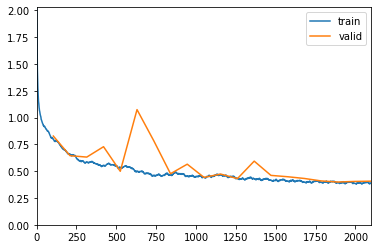

In [3]:
import argparse

train_image_dir = '../ML2021/dataset/train/ct'
train_label_dir = '../ML2021/dataset/train/label'
val_image_dir = '../ML2021/dataset/val/ct'
val_label_dir = '../ML2021/dataset/val/label'
save_model = True

# parser = argparse.ArgumentParser()
# parser.add_argument("--train_image_dir", default='../ML2021/dataset/train/ct',
#     help="The training image nii directory.")
# parser.add_argument("--train_label_dir", default='../ML2021/dataset/train/label',
#     help="The training label nii directory.")
# parser.add_argument("--val_image_dir", default='../ML2021/dataset/val/ct',
#     help="The validation image nii directory.")
# parser.add_argument("--val_label_dir", default='../ML2021/dataset/val/label',
#     help="The validation label nii directory.")
# parser.add_argument("--train_image_dir", default='dataset/mlimg',
#                     help="The training image nii directory.")
# parser.add_argument("--train_label_dir", default='dataset/mllabel',
#                     help="The training label nii directory.")
# parser.add_argument("--val_image_dir", default='dataset/mlvalimg',
#                     help="The validation image nii directory.")
# parser.add_argument("--val_label_dir", default='dataset/mlvallabel',
#                     help="The validation label nii directory.")
# parser.add_argument("--save_model", default=True,
#     help="Whether to save the trained model.")
# args = parser.parse_args()

# main(args)
main(train_image_dir,train_label_dir,val_image_dir,val_label_dir,save_model)